# Let's start by installing all required libraries

In [1]:
!pip install numpy scikit_learn matplotlib seaborn pandas tifffile -q

## Load a csv table containing morphometric measurements for single cells as well as manual annotations of their cell cycle phase

In [3]:
import pandas as pd

data_wt = pd.read_csv("../data/wt_measurements.csv")

## Take a look at our data

In [10]:
data_wt

,Cell ID,Area,Perimeter,Length,Width,Eccentricity,Irregularity,Cell Cycle Phase,Area_scaled,Perimeter_scaled,Length_scaled,Width_scaled,Eccentricity_scaled,Irregularity_scaled
0,5,204,60,15.000000,15.000000,0.000000,4.200840,1,-1.649815,-1.876776,-2.056719,-1.491292,-3.371588,-0.734718
1,60,442,93,24.698178,21.189620,0.513745,4.423559,3,1.758735,1.664950,1.410927,1.569969,0.358666,0.229600
2,54,322,80,21.260292,18.439089,0.497783,4.458226,2,0.040138,0.269725,0.181689,0.209612,0.242762,0.379699
3,64,314,76,20.000000,18.000000,0.435890,4.288928,1,-0.074435,-0.159575,-0.268937,-0.007553,-0.206636,-0.353319
4,6,217,66,17.204651,15.000000,0.489760,4.480372,1,-1.463634,-1.232826,-1.268432,-1.491292,0.184510,0.475587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,55,377,82,23.000000,18.000000,0.622514,4.223215,3,0.827828,0.484375,0.803732,-0.007553,1.148423,-0.637842
148,57,379,86,22.360680,20.396078,0.409878,4.417523,2,0.856472,0.913675,0.575139,1.177499,-0.395505,0.203467
149,31,298,74,19.000000,18.000000,0.320145,4.286705,2,-0.303581,-0.374225,-0.626493,-0.007553,-1.047045,-0.362945
150,71,432,92,25.709920,20.615528,0.597524,4.426352,3,1.615519,1.557625,1.772682,1.286034,0.966973,0.241694


<Axes: >

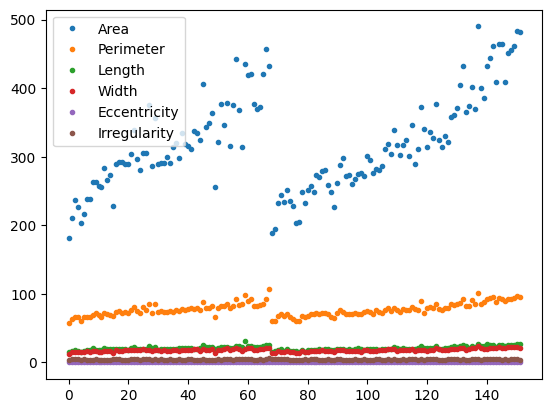

In [5]:
data_wt[[ 'Area', 'Perimeter', 'Length', 'Width', 'Eccentricity',
       'Irregularity']].plot(ls='',marker='.')

<Axes: >

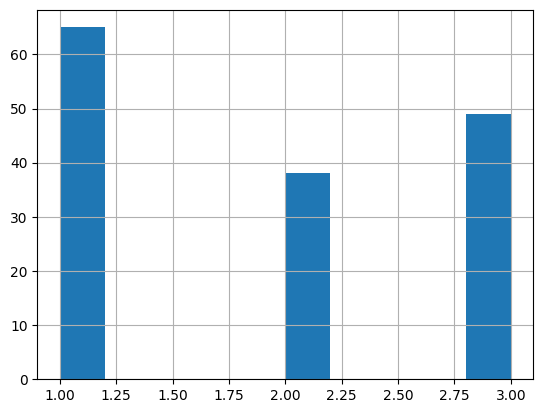

In [7]:
data_wt['Cell Cycle Phase'].hist()

## Let's try to create a basic classifier for cell cycle stage

In [9]:
from sklearn.preprocessing import StandardScaler

rows, columns = data_wt.shape

## shuffle data
data_wt = data_wt.sample(frac=1,replace=False,random_state=0).reset_index(drop=True)

## standardize variables
cols = ['Area', 'Perimeter', 'Length', 'Width', 'Eccentricity','Irregularity']

for col in cols:
  scaler = StandardScaler()
  data_wt[col+"_scaled"] = scaler.fit_transform(data_wt[[col]])

## split into train, test
train = data_wt.loc[0:int(rows*0.8), :].copy() #separates 80% of data as training data
test = data_wt.loc[int(rows*0.8):, :].copy() #separates 20% of data as validation data

In [11]:
from sklearn.linear_model import LogisticRegression

x_cols = ['Area', 'Perimeter', 'Length', 'Width', 'Eccentricity','Irregularity']
y_col = 'Cell Cycle Phase'

# fit on training set
clf = LogisticRegression().fit(train[x_cols],train[y_col])

# predictions on test set
preds = clf.predict(test[x_cols])
# accuracy on test set
sum(preds==test[y_col])/test.shape[0]

/Users/bsaraiva/mambaforge/envs/bioimagecourse/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5806451612903226

In [12]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

conf_mat = confusion_matrix(test[y_col],preds,normalize='true')
conf_mat

array([[1.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.5 ],
       [0.25, 0.  , 0.75]])

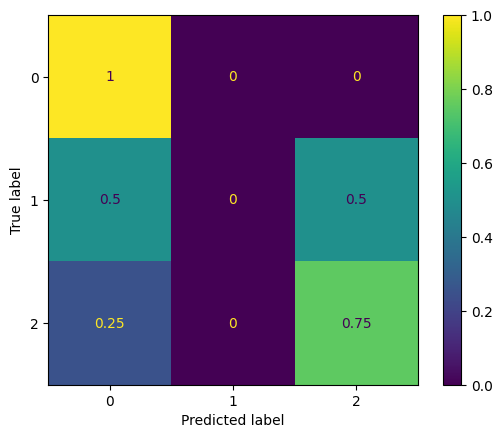

In [13]:
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()

## Accuracy is not necessarily a good metric...
## Could this crappy model be explained by class inbalance?

We have 56 cells in phase 1, 28 cells in phase 2 and 38 cells in phase 3


<Axes: >

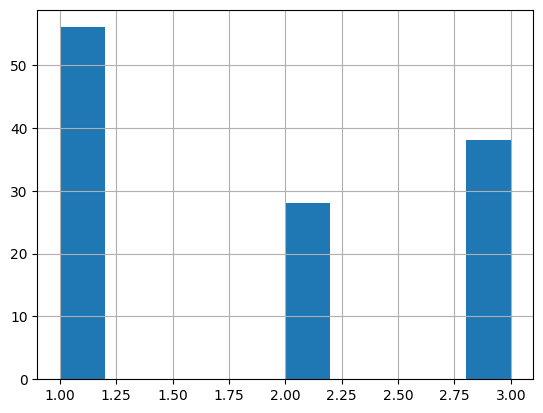

In [18]:
p1, p2, p3 = train[train['Cell Cycle Phase']==1].shape[0], train[train['Cell Cycle Phase']==2].shape[0], train[train['Cell Cycle Phase']==3].shape[0]
print(f"We have {p1} cells in phase 1, {p2} cells in phase 2 and {p3} cells in phase 3")
train['Cell Cycle Phase'].hist()

## We need to balance our classes, we can start by trying to oversample the minority classes

<Axes: >

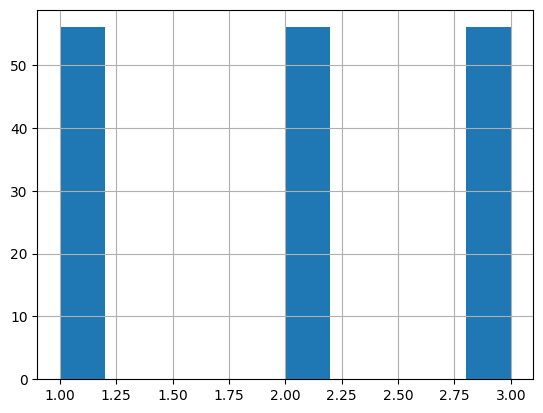

In [23]:
train_oversampled = pd.concat([train,train[train['Cell Cycle Phase']==2].sample(n=p1-p2,replace=True) ]).reset_index(drop=True)
train_oversampled = pd.concat([train_oversampled,train[train['Cell Cycle Phase']==3].sample(n=p1-p3,replace=True) ]).reset_index(drop=True)
train_oversampled['Cell Cycle Phase'].hist()

## Let's try again training the classifier and see if it improved

array([[0.44444444, 0.55555556, 0.        ],
       [0.        , 0.8       , 0.2       ],
       [0.        , 0.25      , 0.75      ]])

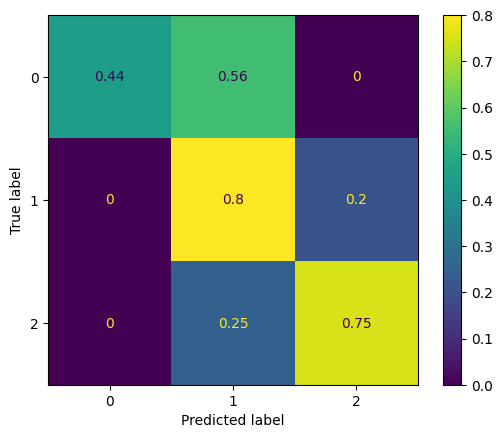

In [25]:
from sklearn.linear_model import LogisticRegression

x_cols = [col+'_scaled' for col in cols]
y_col = 'Cell Cycle Phase'

# fit on training set
clf = LogisticRegression().fit(train_oversampled[x_cols],train_oversampled[y_col])

# predictions on test set
preds = clf.predict(test[x_cols])

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

conf_mat = confusion_matrix(test[y_col],preds,normalize='true')
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()
conf_mat

## Better but still not great, let's try other classifiers
### Thankfully, all classifiers in `sklearn` obey the same API, ie, they all have the methods:

* `fit()`
* `predict()`
* `predict_proba()`